In [1]:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# Insert local path to MAVE-NN at beginning of Python's path
import sys
sys.path.insert(0, '/Users/annzhu/Desktop/phillipslab/mavenn')

#Load mavenn
import mavenn

In [3]:
# Choose dataset
data_name = 'yehS'

print(f"Loading dataset '{data_name}' ")

# Load datset
_data_df = pd.read_csv('/Users/annzhu/Desktop/phillipslab/LB_data.csv')
data_df = _data_df[_data_df['gene'].str.contains('yehS')]
data_df = data_df.dropna()
print(len(data_df))
df_bin = pd.DataFrame()

for i in range(len(data_df)):
    ct0, ct1, seq = data_df.iloc[i][['counts_DNA', 'counts_RNA', 'seq']]
    df_ct0 = pd.DataFrame(
        data={
            "ct_0":np.ones(int(ct0)), 
            "ct_1":np.zeros(int(ct0)), 
            "seq":np.full(int(ct0), seq)})
    df_ct1 = pd.DataFrame(
        data={
            "ct_0":np.zeros(int(ct1)), 
            "ct_1":np.ones(int(ct1)), 
            "seq":np.full(int(ct1), seq)})
    df_bin = pd.concat([df_bin, df_ct0, df_ct1])
    
df_bin.reset_index(inplace=True, drop=True)
# df_bin['seq'] = [x[:160] for x in df_bin['seq']]

# Add random set classification: test/training/validation
set_options = ['test', 'training', 'validation']
vals = random.choices(population=set_options, weights=[0.2, 0.6, 0.2], k=len(df_bin))

df_bin.insert(loc=0,
column='set',
value=vals)

# m = data_df['set'].eq('Placeholder')
# data_df.loc[m, 'set'] = np.random.choice(set_options, size=m.sum())

# Get and report sequence length
L = len(df_bin.loc[0, 'seq'])
print(f'Sequence length: {L:d} amino acids')
               
# Preview dataset
df_bin

Loading dataset 'yehS' 
1213
Sequence length: 160 amino acids


,set,ct_0,ct_1,seq
0,test,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
1,training,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
2,training,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
3,test,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
4,training,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
...,...,...,...,...
81863,validation,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...
81864,training,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...
81865,training,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...
81866,validation,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...


In [4]:
# Split dataset
trainval_df, test_df = mavenn.split_dataset(df_bin)

# Show dataset sizes
print(f'Train + val set size : {len(trainval_df):6,d} observations')
print(f'Test set size        : {len(test_df):6,d} observations')

# Preview trainval_df
trainval_df

Training set   :   49,199 observations (  60.10%)
Validation set :   16,332 observations (  19.95%)
Test set       :   16,337 observations (  19.96%)
-------------------------------------------------
Total dataset  :   81,868 observations ( 100.00%)

Train + val set size : 65,531 observations
Test set size        : 16,337 observations


,validation,ct_0,ct_1,seq
0,False,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
1,False,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
2,False,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
3,False,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
4,False,1.0,0.0,CTGGCGATTCGTCTGGAAGATAACGGCCAGGCCGAGTTGATATTGC...
...,...,...,...,...
65526,True,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...
65527,False,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...
65528,False,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...
65529,True,0.0,1.0,AAAGAGATTCGTATGGAAGATAACGGCCAGGCCGAGGTGAATTTGC...


In [5]:
# Get the length of the sequence
L = len(df_bin['seq'][0])
# Get the column index for the counts
y_cols = trainval_df.columns[1:-1]
# Get the number of count columns
len_y_cols = len(y_cols)

In [6]:
from mavenn.src.layers.gpmap import GPMapLayer

# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant

class ThermodynamicLayer(GPMapLayer):
    """
    Represents a three-stage thermodynamic model
    containing the states:
    1. free DNA
    2. YieP-DNA binding
    3. RNAP-DNA binding
    """

    def __init__(self,
                 tf_start,
                 tf_end,
                 rnap_start,
                 rnap_end,
                 *args, **kwargs):
        """Construct layer instance."""

        # Call superclass
        super().__init__(*args, **kwargs)

        # set attributes
        self.tf_start = tf_start             # transcription factor starting position
        self.tf_end = tf_end                 # transcription factor ending position
        self.L_tf = tf_end - tf_start        # length of transcription factor
        self.rnap_start = rnap_start         # RNAP starting position
        self.rnap_end = rnap_end             # RNAP ending position
        self.L_rnap = rnap_end - rnap_start  # length of RNAP

        # define bias/chemical potential weight for TF/CRP energy
        self.theta_tf_0 = self.add_weight(name='theta_tf_0',
                                          shape=(1,),
                                          initializer=Constant(1.),
                                          trainable=True,
                                          regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap energy
        self.theta_rnap_0 = self.add_weight(name='theta_rnap_0',
                                            shape=(1,),
                                            initializer=Constant(1.),
                                            trainable=True,
                                            regularizer=self.regularizer)

        # initialize the theta_tf
        theta_tf_shape = (1, self.L_tf, self.C)
        theta_tf_init = np.random.randn(*theta_tf_shape)/np.sqrt(self.L_tf)

        # define the weights of the layer corresponds to theta_tf
        self.theta_tf = self.add_weight(name='theta_tf',
                                        shape=theta_tf_shape,
                                        initializer=Constant(theta_tf_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        # define theta_rnap parameters
        theta_rnap_shape = (1, self.L_rnap, self.C)
        theta_rnap_init = np.random.randn(*theta_rnap_shape)/np.sqrt(self.L_rnap)

        # define the weights of the layer corresponds to theta_rnap
        self.theta_rnap = self.add_weight(name='theta_rnap',
                                          shape=theta_rnap_shape,
                                          initializer=Constant(theta_rnap_init),
                                          trainable=True,
                                          regularizer=self.regularizer)


    def call(self, x):
        """Process layer input and return output.

        x: (tensor)
            Input tensor that represents one-hot encoded
            sequence values.
        """

        # extract locations of binding sites from entire lac-promoter sequence.
        # for transcription factor and rnap
        x_tf = x[:, self.C * self.tf_start:self.C * self.tf_end]
        x_rnap = x[:, self.C * self.rnap_start: self.C * self.rnap_end]

        # reshape according to tf and rnap lengths.
        x_tf = tf.reshape(x_tf, [-1, self.L_tf, self.C])
        x_rnap = tf.reshape(x_rnap, [-1, self.L_rnap, self.C])

        # compute delta G for crp binding
        G_C = self.theta_tf_0 + \
            tf.reshape(K.sum(self.theta_tf * x_tf, axis=[1, 2]),
                       shape=[-1, 1])

        # compute delta G for rnap binding
        G_R = self.theta_rnap_0 + \
            tf.reshape(K.sum(self.theta_rnap * x_rnap, axis=[1, 2]),
                       shape=[-1, 1])

        # compute phi
        numerator_of_rate = K.exp(-G_R)
        denom_of_rate = 1.0 + K.exp(-G_C) + K.exp(-G_R)
        phi = numerator_of_rate/denom_of_rate

        return phi

In [13]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'tf_start': -2+115,  # starting position of the YieP -35
                'tf_end': 5+115,  # ending position of the YieP -20
                'rnap_start': -25+115,  # starting position of the RNAP -67
                'rnap_end': 17+115,   # ending position of the RNAP -44
                'L': L,
                'C': 4,
                'theta_regularization': 0.1}

# Create model
model = mavenn.Model(L=L,
                     Y=len_y_cols,
                     alphabet='dna',
                     regression_type='MPA',
                     gpmap_type='additive',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer);

# Set training data
model.set_data(x=trainval_df['seq'],
               y=trainval_df[y_cols],
               validation_flags=trainval_df['validation'],
               shuffle=True);

# Fit model to data
model.fit(learning_rate=1e-4,
          epochs=2000,
          batch_size=200,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=False,
          verbose=False);

N = 65,531 observations set as training data.
Using 24.9% for validation.
Data shuffled.
Time to set data: 2.06 sec.
Training time: 2207.4 seconds


In [ ]:
model.save('yehS_thermodynamic_mpa')

In [8]:
# Compute predictive information on test data
I_pred, dI_pred = model.I_predictive(x=test_df['seq'], y=test_df[y_cols])
print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

test_I_pred: 0.188 +- 0.006 bits


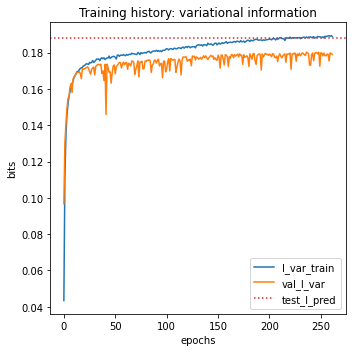

In [9]:
# Create figure and axes for plotting
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# Plot I_var_train, the variational information on training data as a function of epoch
ax.plot(model.history['I_var'], label=r'I_var_train')

# Plot I_var_val, the variational information on validation data as a function of epoch
ax.plot(model.history['val_I_var'], label=r'val_I_var')

# Show I_pred_test, the predictive information of the final model on test data
ax.axhline(I_pred, color='C3', linestyle=':', label=r'test_I_pred')

# Style plot
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('Training history: variational information')
ax.legend()

plt.tight_layout()

In [10]:
# Get the trained model parameters
# Retrieve G-P map parameter dict and view dict keys
param_dict = model.layer_gpmap.get_params()
param_dict.keys()

dict_keys(['theta_0', 'theta_lc'])

In [11]:
# delta_G_I = param_dict['theta_dG_I']  # Gibbs energy of Interaction (scalar)
# print(f'YieP-RNAP interaction energy = {delta_G_I*0.62:.3f} k_cal/mol')

[[-4.08388413e-02  2.04110369e-02 -1.61211953e-01 -8.81329253e-02]
 [-1.17283091e-01 -4.82987799e-02 -1.91937089e-01 -6.08899258e-03]
 [ 1.48893282e-01 -1.55736044e-01 -6.79871663e-02  4.05080140e-01]
 [-6.34159029e-01  1.06044367e-01  3.01803667e-02 -5.50251544e-01]
 [-1.22571504e-02  9.66311470e-02  4.27403837e-01 -3.47899169e-01]
 [-1.67187214e-01  6.50038064e-01 -2.15797108e-02  1.32119447e-01]
 [-9.03553218e-02 -1.08744845e-01 -7.46489763e-02  4.32017565e-01]
 [-4.46604818e-01  2.48253345e-01  4.97042507e-01  1.47589399e-02]
 [ 4.40075874e-01 -4.72333990e-02 -2.66233236e-01  1.34705584e-02]
 [-9.03099597e-01  3.33639905e-02  1.49896055e-01  9.24755484e-02]
 [-2.52851278e-01  3.52016687e-01 -2.28161529e-01  4.24674600e-01]
 [ 8.24908912e-02 -2.65441477e-01  1.02669910e-01  9.11562368e-02]
 [ 2.65127331e-01  4.14092951e-02  1.32572174e-01 -4.68165308e-01]
 [ 4.16370094e-01 -5.60680628e-01  5.60856201e-02 -2.56294217e-02]
 [ 2.01017693e-01  4.65324759e-01 -1.34093106e-01  2.62478322e

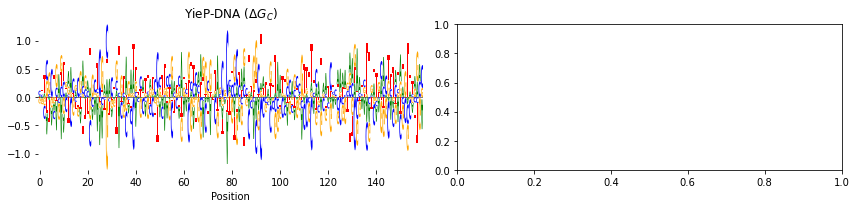

In [18]:
# import logomaker
import logomaker

# Get the \Delta G_C trained values (theta_tf)
tf_weights = param_dict['theta_lc']
# Convert them to pandas dataframe
tf_df = pd.DataFrame(tf_weights, columns=model.alphabet)


# plot logos
fig, axs = plt.subplots(1, 2, figsize=[12, 3])

# sequence logo for the YieP-DNA binding energy matrix
logo = logomaker.Logo(tf_df,  ax=axs[0], center_values=True)
axs[0].set_title('YieP-DNA ($\Delta G_C$)')
axs[0].set_xlabel('Position')
logo.style_spines(visible=False)


print(tf_weights)
plt.tight_layout()

In [2]:
maximum = np.max(np.abs(tf_weights))
fig,ax = plt.subplots(figsize=((10,2)))
plt.imshow(-np.transpose(tf_weights), origin='upper', cmap='coolwarm', vmax=maximum, vmin=-maximum)
plt.xlabel('Position')
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['A','C','G','T'])
ax.grid(False)
plt.colorbar()

NameError: name 'np' is not defined